# Multi-objective Optimisation: Nobody Gets Exactly What They Want
### An introduction to Pareto optimality

In many real-world problems, several factors influence decision-making. Often, these factors compete with each other as they have their own  interests or "objective". In groundwater management, for example, 'meeting the demand' (i.e., maximising pumping at production wells) often competes with 'protecting the environment' (i.e., minimising drawdown at groundwater-dependent ecosystems). Decision-making should consider the trade-off between these competing objective in an attempt to make everyone happy. Of course, we cannot please everyone, so we have to find a set of decisions which is the best compromise between competing interests -- this is the central idea for Multi-Objective Optimisation (MOO).

This notebook is Part 1 of MOO Tutorials. Before we give you a walk-through on how to use MOO tools, we have to understand first the central concept in MOO, the Pareto optimality, which is just a fancy way of saying that in any decisions made, not everyone is absolutely happy but we are all (just a little bit) unhappy together, so yay!

For this tutorial, we will start with a modified Kursawe problem. 

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

Let us first see what the problem looks like. The original Kursawe problem has two objectives and three-dimensional inputs. For the purpose of this tutorial, we modified it such that we only have two-dimensional inputs for easier visualisation of the objective space.

The objective functions are given by:

In [2]:
def kursawe_2d(x):
    x = np.array(x)
    obj1 = -10 * np.exp(-0.2 * np.sqrt(x[0]**2 + x[1]**2))
    obj2 = np.abs(x[0])**0.8 + 5 * np.sin(x[0]**3) + np.abs(x[1])**0.8 + 5 * np.sin(x[1]**3)
    return obj1, obj2

Think of these objectives as two different interests that influence decision-making and x1 and x2 are levers we adjust to satisfy these objectives. Suppose we want both objectives minimized. If only they could agree on exactly the same values for x1 and x2, then we have a concensus.

Let's create an array of decision variable values and calculate the objective values to see how each objective looks like with respect to the decision space.

In [3]:
n_samples = 100

x1_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x2_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([kursawe_2d([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]


Objective 1 Minimum:
  Value: -8.973565
  x1: 0.050505
  x2: 0.050505

Objective 2 Minimum:
  Value: -7.105523
  x1: 1.666667
  x2: 1.565657


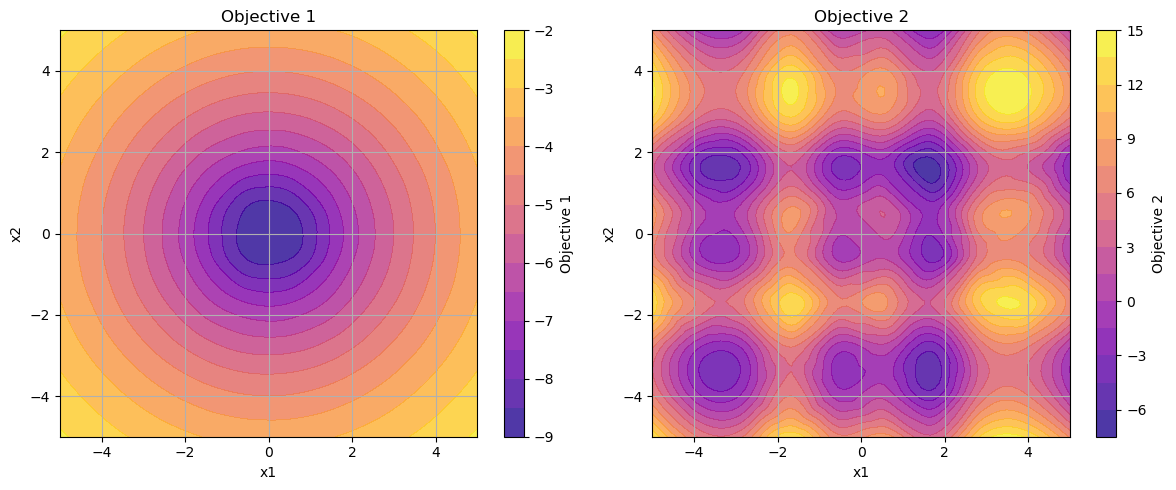

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

grid_size = 100
xi = np.linspace(min(x1), max(x1), grid_size)
yi = np.linspace(min(x2), max(x2), grid_size)
xi_grid, yi_grid = np.meshgrid(xi, yi)

zi1 = griddata((x1, x2), obj1, (xi_grid, yi_grid), method='cubic')
contour1 = ax1.contourf(xi_grid, yi_grid, zi1, 15, cmap='plasma', alpha=0.8)
fig.colorbar(contour1, ax=ax1, label='Objective 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Objective 1')
ax1.grid(True)

zi2 = griddata((x1, x2), obj2, (xi_grid, yi_grid), method='cubic')
contour2 = ax2.contourf(xi_grid, yi_grid, zi2, 15, cmap='plasma', alpha=0.8)
fig.colorbar(contour2, ax=ax2, label='Objective 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Objective 2')
ax2.grid(True)

min_obj1_idx = np.nanargmin(zi1)
min_obj1_row, min_obj1_col = np.unravel_index(min_obj1_idx, zi1.shape)
min_obj1_x1 = xi_grid[min_obj1_row, min_obj1_col]
min_obj1_x2 = yi_grid[min_obj1_row, min_obj1_col]
min_obj1_value = zi1[min_obj1_row, min_obj1_col]

min_obj2_idx = np.nanargmin(zi2)
min_obj2_row, min_obj2_col = np.unravel_index(min_obj2_idx, zi2.shape)
min_obj2_x1 = xi_grid[min_obj2_row, min_obj2_col]
min_obj2_x2 = yi_grid[min_obj2_row, min_obj2_col]
min_obj2_value = zi2[min_obj2_row, min_obj2_col]

print("Objective 1 Minimum:")
print(f"  Value: {min_obj1_value:.6f}")
print(f"  x1: {min_obj1_x1:.6f}")
print(f"  x2: {min_obj1_x2:.6f}")
print("\nObjective 2 Minimum:")
print(f"  Value: {min_obj2_value:.6f}")
print(f"  x1: {min_obj2_x1:.6f}")
print(f"  x2: {min_obj2_x2:.6f}")

plt.tight_layout()
plt.show()

The minima for each objectives are at different locations in the decision space. This means we cannot find a single set of decision variables that can make both objectives minimized at the same time. Looks like we have to make a compromise, but how?

Let's have a look at the objective space below. The blue dots shown are just some of the points we have tried. Try changing the values of x1 and x2 to see how the objectives change.

In [5]:
from ipywidgets import interact, FloatSlider

def plot_objectives(x1_val, x2_val):
    # Calculate objectives for the given x1, x2 values using Kursawe function
    new_obj1 = -10 * np.exp(-0.2 * np.sqrt(x1_val**2 + x2_val**2))
    new_obj2 = abs(x1_val)**0.8 + 5 * np.sin(x1_val**3) + abs(x2_val)**0.8 + 5 * np.sin(x2_val**3)

    plt.figure(figsize=(6, 5))
    plt.scatter(obj1, obj2, alpha=0.3, label='solutions previously tried')

    rect_width = -2 - new_obj1 
    rect_height = 15 - new_obj2
    rect = plt.Rectangle((new_obj1, new_obj2), rect_width, rect_height, 
                         color='peachpuff', alpha=0.5, label = 'dominance region')
    plt.gca().add_patch(rect)
    
    plt.scatter(new_obj1, new_obj2, color='red', s=40, label=f'Selected (x1={x1_val:.2f}, x2={x2_val:.2f})')

    plt.xlabel('Objective 1 (minimise)')
    plt.ylabel('Objective 2 (minimise)')
    plt.xlim((-10, -2))
    plt.ylim((-7.5, 15))
    plt.title('Objective Space')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.annotate(f'Obj1: {new_obj1:.4f}\nObj2: {new_obj2:.4f}', 
                 xy=(new_obj1, new_obj2), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    plt.show()

interact(plot_objectives, 
         x1_val=FloatSlider(min=-5, max=5, step=0.1, value=0, description='x1:'),
         x2_val=FloatSlider(min=-5, max=5, step=0.1, value=0, description='x2:'))



interactive(children=(FloatSlider(value=0.0, description='x1:', max=5.0, min=-5.0), FloatSlider(value=0.0, des…

<function __main__.plot_objectives(x1_val, x2_val)>

We will refer to points in the objective space as *objective positions*. All positions inside the rectangle have worse values of both objectives than the red dot. We say that the red dot *dominates* these solutions. Of course, if we want to be absolutely happy, we want a solution that can dominate all other positions in this objective space, that is, placing the red dot at the bottom left corner of the plot (-10,-7.5). Keep trying to move the red dot as close to this corner as possible. 

It seems that we can only move the red dot towards the bottom left corner up to a certain extent as if there is an invisible barrier that prevents us from moving the red dot further down. That invisible barrier coincides with the so-called **Pareto front**. It is a trade-off function that represent the best compromise between the two objectives. At any given value of one objective, we can only improve the value of the other objective up to the Pareto front, and vice versa. This limitation can be due to the feasible values of the decision variables (e.g., pumping capacities of wells), constraints (e.g., allowable drawdown) or a combination of both. 

 As decision-makers, we cannot provide absolute happiness for competing interests at the same time, but we can find a set of compromises that make us all relatively happy -- that set of compromises is called the **Pareto optimal set** of decisions. We want a robust collection of these decisions to provide some flexibility.

Can you try finding values for x1 and x2 along the Pareto front?

In [6]:
archive_dv = pd.read_csv(os.path.join('demo_files', 'kursawe2d', 'kur.archive.dv_pop.csv'))
archive_obs = pd.read_csv(os.path.join('demo_files', 'kursawe2d', 'kur.archive.obs_pop.csv')).sort_values(by='obj1')

pareto_front_true = pd.read_csv(os.path.join('demo_files', 'kursawe2d', 'kursawe2d_solution_obj.csv')).sort_values(by='obj1')

def plot_objectives(x1_val, x2_val):
    # Calculate objectives for the given x1, x2 values using Kursawe function
    new_obj1 = -10 * np.exp(-0.2 * np.sqrt(x1_val**2 + x2_val**2))
    new_obj2 = abs(x1_val)**0.8 + 5 * np.sin(x1_val**3) + abs(x2_val)**0.8 + 5 * np.sin(x2_val**3)

    plt.figure(figsize=(6, 5))
    plt.plot(pareto_front_true['obj1'], pareto_front_true['obj2'], color='blue', label='Pareto front')
    plt.scatter(new_obj1, new_obj2, color='red', s=40, label=f'Selected (x1={x1_val:.2f}, x2={x2_val:.2f})')

    plt.xlabel('Objective 1 (minimise)')
    plt.ylabel('Objective 2 (minimise)')
    plt.xlim((-10.5, -2))
    plt.ylim((-8.5, 15))
    plt.title('Objective Space')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add hint text showing the first and last points on the Pareto front
    end_point_1 = archive_dv.loc[archive_dv['real_name'] == archive_obs.iloc[0]['real_name']]
    end_point_2 = archive_dv.loc[archive_dv['real_name'] == archive_obs.iloc[-1]['real_name']]
    
    hint_text = (f"Hint:\nEnd point 1: x1={end_point_1['x1'].item():.4f}, x2={end_point_1['x2'].item():.4f}\n"
                f"End point 2: x1={end_point_2['x1'].item():.4f}, x2={end_point_2['x2'].item():.4f}")
    
    plt.figtext(0.95, 0.15, hint_text, 
                bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
                fontsize=9)
    plt.annotate(f'Obj1: {new_obj1:.4f}\nObj2: {new_obj2:.4f}', 
                 xy=(new_obj1, new_obj2), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    plt.show()

interact(plot_objectives, 
         x1_val=FloatSlider(min=-5, max=5, step=0.1, value=0, description='x1:'),
         x2_val=FloatSlider(min=-5, max=5, step=0.1, value=0, description='x2:'))

interactive(children=(FloatSlider(value=0.0, description='x1:', max=5.0, min=-5.0), FloatSlider(value=0.0, des…

<function __main__.plot_objectives(x1_val, x2_val)>

Often, it is analytically impossible to derive the Pareto front as the relationship between the competing objectives cannot be mathematically represented in a simple equation. To approximate the Pareto front, we obtain a set of Pareto optimal solutions by iteratively trying out a large set of decision variables.

It is difficult and impractical to manually find a robust set of Pareto optimal decisions. The good news is we have decision-support tools to help us with this task. A tool in PEST++ suite, pestpp-mou, is particularly designed to solve these kinds of optimisation problems using *evolutionary algorithm (EA)*. A tutorial on the use of pestpp-mou is provided in GMDSI notebooks (https://github.com/gmdsi/GMDSI_notebooks).

pestpp-mou iteratively tries a set of decision values (termed as *population* in EA) and have each of them evaluated through the model -- that's a lot of model runs! Think about these objectives as outputs of a complex numerical model (e.g., groundwater model), which runs hours to evaluate a set of decision inputs (imagine having more than two values to adjust!) and determine the values of the objectives. At each iteration, pestpp-mou keeps a record of **non-dominated** positions -- these are the best compromise solutions among those that have been tried up to the current iteration and will be simply referred to as the *front* in that iteration. With a few more iterations, the front will converge to the Pareto front. It will take forever to manually obtain these Pareto optimal decision sets!

There is a way to make this whole process less painful. We will demonstrate that in Part 3 of this tutorial. In a nutshell, we can employ an approximate model to emulate the objective values instead of running the expensive model, but there's a caveat to this -- the emulations are uncertain, which means the emulated objective values have errors that we have to deal with.

In the next tutorial, we will introduce the concept of Probabilistic Pareto Dominance, a generalisation of Pareto Dominance under uncertainty.

### Relevant works:
Siade, A. J., Rathi, B., Prommer, H., Welter, D., & Doherty, J. (2019). Using heuristic multi-objective optimization for quantifying predictive uncertainty associated with groundwater flow and reactive transport models. Journal of Hydrology, 577(July), 123999. https://doi.org/10.1016/j.jhydrol.2019.123999

White, J. T., Knowling, M. J., Fienen, M. N., Siade, A., Rea, O., & Martinez, G. (2022). A model-independent tool for evolutionary constrained multi-objective optimization under uncertainty. Environmental Modelling & Software, 149, 105316. https://doi.org/10.1016/j.envsoft.2022.105316